# Tutorial for running a subset of the NYC foods from Open Food Facts (https://world.openfoodfacts.org/) through Eirene.

## Day 1 of 2

### First we load in packages to the environment

In [1]:
## Load packages

using Pkg
using JLD
using Eirene
using Combinatorics
using SparseArrays
using Plots
theme(:dark)
using LightGraphs
using GraphPlot

include("PH_helper_functions.jl")


┌ Info: Recompiling stale cache file /Users/annblevins/.julia/compiled/v1.1/JLD/l8ijy.ji for JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/annblevins/.julia/compiled/v1.1/Eirene/mCiG1.ji for Eirene [9c0f25c4-2ca1-5870-89f6-52640788da1d]
└ @ Base loading.jl:1184
┌ Warning: Package Eirene does not have Pkg in its dependencies:
│ - If you have Eirene checked out for development and have
│   added Pkg as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Eirene
└ Loading Pkg into Eirene from project dependency, future warnings for Eirene are suppressed.


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10423945283032288717\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9839362590084731263\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-10423945283032288717\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: Recompiling stale cache file /Users/annblevins/.julia/compiled/v1.1/LightGraphs/Xm08G.ji for LightGraphs [093fc24a-ae57-5d10-9952-331d41423f4d]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/annblevins/.julia/compiled/v1.1/GraphPlot/bUwXr.ji for GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
└ @ Base loading.jl:1184


plotBarcode (generic function with 1 method)

### Next load in the NYC food data. 

We will see a list of food products (products_list), a list of ingredients used in the food (ingredients_list), the incidence matrix indicating which ingredients are in which food products (ingredientsByProducts), and the sugar content of each product. Note for means of this tutorial any product with missing sugar information was given a value of 500.

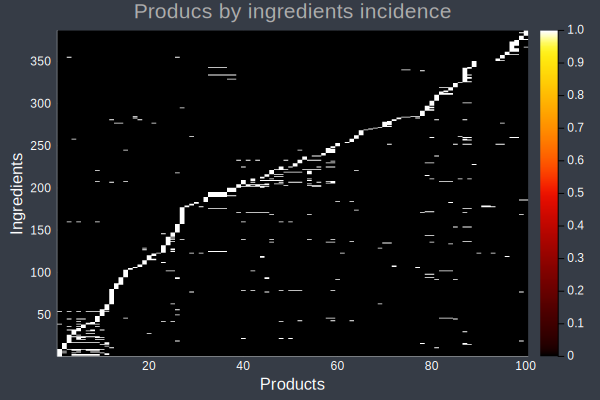

In [2]:
## Load in incidence matrix
loaded_data = load("ingredientsByProducts.jld")

products_list = loaded_data["products_list"]
ingredients_list = loaded_data["ingredients_list"]
ingredientsByProducts = loaded_data["ingredientsByProducts"]
sugars = loaded_data["sugars"]

# Remove loaded_data to free up memory
loaded_data = nothing
GC.gc()


# Quickly view the productsByIngredients incidence matrix
gr()
heatmap(ingredientsByProducts)
title!("Producs by ingredients incidence")
xlabel!("Products")
ylabel!("Ingredients")


## Convert incidence matrix to the proper format for Eirene

Eirene can handle data in the form of an incidence matrix but requires it be converted into a simplex stream. Generally, we need to enumerate and weight each simplex within our final simplicial complex and store this in particular formats for Eirene. We will store the simplices themselves in the array of arrays E, which first has the nodes, then the edges, then the 2-simplices, and so on. Next we need to create the boundary operator D which tells us which simplices are faces of other simplices. Finally we take speciic projections of D and E (called rv, cp, and dv) together with a simplex-weight vector fv and pass these objects to eirene.

In [3]:
## First we create lists of simplices of each dimension we care about

nIngredients = size(ingredientsByProducts)[1]
nProducts = size(ingredientsByProducts)[2]
node_list = 1:nProducts


edge_list, simp2_list, simp3_list = createSimplexLists(ingredientsByProducts,ingredients_list)
# Now edge_list is an array of the edges, simp2_list an array of the 2-simplices, and so on.

# Count the number of simplices we have in each dimension
nNodes = length(node_list)
nEdges = length(edge_list)
nsimp2 = length(simp2_list)
nsimp3 = length(simp3_list)

println("Created lists of nodes, 1-simplices, 2-simplices, and 3-simplices")


# Combine these lists into the full cell list E
println("Creating cell list... ")
E = createCellList(nNodes,edge_list,simp2_list)
nCells = length(E)

println("Finished constructing cell list with $nNodes nodes, $nEdges edges, $nsimp2 2-simplices, and $nsimp3 3-simplices.")

Created lists of nodes, 1-simplices, 2-simplices, and 3-simplices
Creating cell list... 
Finished constructing cell list with 100 nodes, 535 edges, 993 2-simplices, and 1177 3-simplices.


Here we compute the boundary matrix D. This matrix is composed of smaller boundary matrices that describe faces of simplices in a specific dimension. For example, the D_2 matrix of size nEdges x n2simp describes which edges make up each 2-simplex. The D_1 matrix is nNodes x nEdges and records which nodes parent each edge. The final boundary matrix D is an nCells x nCells matrix with D_1 and D_2 in the appropriate spots, and 0 elsewhere.

In [4]:

println("Constructing D matrix...")
D = createDMatrix(E,nNodes,nEdges)
println("Finished constructing boundary matrix D.")

# D is a sparse matrix due to its size, so we can take the following 
# slices of the sparse matrix which will be enough to recover all the 
# information that eirene needs.
rv = D.rowval
cp = D.colptr
dv = length.(E).-1

# Assign simplex weights based on the participating food which has 
# the largest sugar content. This is where we use the node weights
# (sugar content) to weight connections.

node_weights = sugars
fv = determineCellWeight.(E)

println("Ready for eirene!")


Constructing D matrix...
Finished constructing boundary matrix D.
Ready for eirene!


## Run Eirene! 

We pass our constructed objects that describe the filtration (rv,cp,dv, and fv) to eirene which returns a list C of all the persistent homology information.

In [5]:
C = eirene(rv=rv,cp=cp,dv=dv,fv=fv)

println("Finished running persistent homology!")

Finished running persistent homology!


## Vlsualize outputs

### Barcodes and Betti curves
First we wil look at the barcode output which shows each persistent cavity as a bar. Then we will plot the Betti curves, which records the number of cavities alive at each filtration value

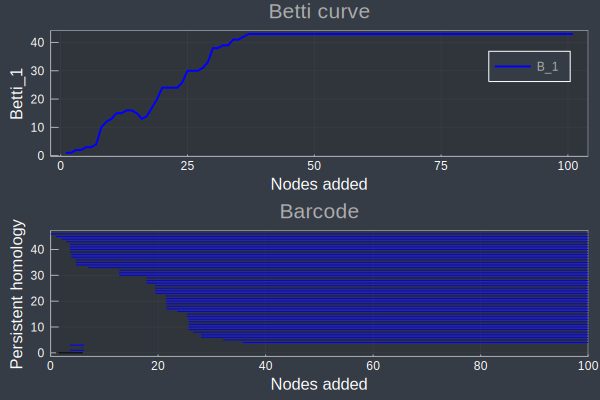

In [6]:
# Calculate Betti_1 from the barcode output
bettiCurve_1 = bettiCurveFromBarcode(barcode(C,dim=1),nNodes,node_weights)


# Plot!
p1a = plot(1:(nNodes+1),bettiCurve_1, label = ["B_1"], linewidth = 2)
xlabel!("Nodes added")
ylabel!("Betti_1")
title!("Betti curve")
p1b = plotBarcode(barcode(C,dim=1),nNodes)
title!("Barcode")
xlabel!("Nodes added")
ylabel!("Persistent homology")

plot(p1a,p1b,layout = (2,1), framestyle = :box)

## Which food to make?

Now that we have discovered many cavities do indeed exist within the NYC food space, let's zero in on a few specific cavities so we can brainstorm exactly what sort of novel food combination is missing (and would be a big hit!).

In this next section we'll look at specific representatives and do some food brainstorming!

In [7]:
# Pick persistent cavity number
class_number = 45

# Extract nodes involved in the cavity and plot cycle
rep_i = classrep(C, class = class_number, dim=1)
nodes_in_cycle = unique(collect(Iterators.flatten(edge_list[rep_i])))
food_in_cycle = products_list[nodes_in_cycle]

g = SimpleGraph(nNodes)
for edge in edge_list
    add_edge!(g, edge[1], edge[2])
end

sub_graph1,vmap = induced_subgraph(g,nodes_in_cycle)
display(gplot(sub_graph1, nodelabel = products_list[nodes_in_cycle]))

for product in products_list[nodes_in_cycle]
    println(product)
end



New York Style, Pita Chips, Sea Salt
New York Style, Authentic Baked Panetini, Original
Tabatchnick, New York Style Chicken Broth With Noodles & Vegetables
New York Style, Pita Chips, Red Hot Chili Pepper
Meat Tortellini
